In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37311")

# Import

In [2]:
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
from IPython import display
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
import inspect
import tensorboard
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import itertools
import matplotlib.colors as mcolors
import glob, os
from scipy import ndimage
from random import randrange

In [3]:
import logging
logging.getLogger('lightning').setLevel(0)
pl.utilities.distributed.log.setLevel(logging.ERROR)

In [4]:
import platform
print(platform.platform())

Linux-5.10.133+-x86_64-with-glibc2.35


In [5]:
print(torch.__version__)

1.12.1.post201


In [6]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

# Useful functions

In [7]:
line_styles = ['solid', 'dashed', 'dotted', 'dashdot']

For testing

In [8]:
def central_diffs_x(dataArray) :
    return 0.5*(torch.roll(dataArray, shifts=-1, dims=0) - torch.roll(dataArray, shifts=1, dims=0))
def central_diffs_y(dataArray) :
    return 0.5*(torch.roll(dataArray, shifts=-1, dims=1) - torch.roll(dataArray, shifts=1, dims=1))

In [9]:
def central_diffs_x_2(dataArray) :
    return (torch.roll(dataArray, shifts=-1, dims=0) - 2.*dataArray.clone() + torch.roll(dataArray, shifts=1, dims=0))
def central_diffs_y_2(dataArray) :
    return (torch.roll(dataArray, shifts=-1, dims=1) - 2.*dataArray.clone() + torch.roll(dataArray, shifts=1, dims=1))

In [10]:
def finite_diffs_sqr_2d_array(dataArray) :
    return torch.pow(central_diffs_x(dataArray),2) + torch.pow(central_diffs_y(dataArray),2)
    #return (central_diffs_y(dataArray)).clone()
    #return torch.pow(central_diffs_x_2(dataArray),2) + torch.pow(central_diffs_y_2(dataArray),2)

A function that allows to read the logs in tensorboars format and returns them as a python dictionary:

In [11]:
def get_logs_from_tb(exp_name, version_name, directory='logs/') :
    dictionary = dict()
    # for var in list_of_vars :
    #     dictionary[var] = list()
    file_name = glob.glob(directory + '/' + exp_name + '/' + version_name + '/events.out.*')[-1]
    print(file_name)
    for event in EventFileLoader(file_name).Load() :
        if (len(event.summary.value) > 0) :
            if (event.summary.value[0].tag not in dictionary) :
                dictionary[event.summary.value[0].tag] = []
            (dictionary[event.summary.value[0].tag]).append(event.summary.value[0].tensor.float_val)
    return dictionary

# Data properties

In [12]:
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET'] 

In [13]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA'})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO'})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

In [14]:
features_to_add_to_sample = ['votemper', 'votemper_var', 'diff_votemper_sqr', 'predictor_T', 'predictor_S', 'predictor_TS', 'sigma0_delta']

In [15]:
h = 40 # height of images
w = 40 # width of images

In [16]:
batch_size = 4

# Data classes

## Pytorch dataset (from xarray to torch tensors)

In [17]:
# iterates over time snapshots in an xarray data file and transforms it into a dictionary of pytorch tensors, also performs normalization
class torchDataset(torch.utils.data.Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, xarray_dataset, transform=None):
        self.transform = transform
        full_data_file_len = len(xarray_dataset.t)
        self.data = (xarray_dataset.isel(x_c=slice(None,w), y_c=slice(None,h))).load()
        self.data_file_len = len(self.data.t)
        
    def __len__(self):
        return self.data_file_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            list_idx = idx.tolist()
        else :
            list_idx = idx
        selected_time_frames = self.data.isel(t=list_idx)
        
        # create dictionary of a sample (a batch) containig different features. 
        # This dictionary is sort of an intermediate step, preparing xArray data for trasform into pytorch tensors
        sample = dict()
        sample['mask'] = (selected_time_frames['mask'].values).astype(bool)
        #sample['mask'] = selected_time_frames['votemper'].where(not(selected_time_frames['votemper'].isnan())).values.astype(bool)
        erosion_structure_matrix = np.array([(0,0,1,0,0), (0,1,1,1,0), (1,1,1,1,1), (0,1,1,1,0), (0,0,1,0,0)])
        sample['eroded_mask'] = ndimage.binary_erosion(selected_time_frames['mask'].values, structure=erosion_structure_matrix)
        for feature in features_to_add_to_sample :
            sample['mean_'+feature] = self.data.attrs['mean_'+feature]
            sample['std_'+feature] = self.data.attrs['std_'+feature]
            sample[feature] = selected_time_frames[feature].values
            sample['normalized_'+feature] = selected_time_frames['normalized_'+feature].values
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def restore_units(tensor, sample, reference_feature) :
        return tensor*(sample['std_'+reference_feature].view(-1,1,1))+sample['mean_'+reference_feature].view(-1,1,1)
                
    def normalize(tensor, sample, reference_feature) :
        return (tensor-sample['mean_'+reference_feature].view(-1,1,1))/(sample['std_'+reference_feature].view(-1,1,1))

In [18]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=sample.copy()
        for feature in features_to_add_to_sample :
            transformed_sample[feature] = torch.tensor(sample[feature])
        return transformed_sample

## Lightning data module (split trainig, validation and test data)

In [19]:
xr_dataset = xr.open_zarr(f'{SCRATCH_BUCKET}/data3D_5.zarr', chunks='auto')

In [20]:
xr_dataset

<xarray.Dataset>
Dimensions:            (y_c: 47, x_c: 40, t: 91, z_c: 107, x_r: 40, y_r: 47,
                        z_l: 107)
Coordinates: (12/17)
    area               (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    depth_c            (z_c) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    depth_l            (z_l) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    e1t                (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e2t                (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e3t                (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    ...                 ...
  * x_c                (x_c) int64 1 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40
  * x_r                (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 37.5 38.5 39.5 40.5
  * y_c                (y_c) int64 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47
  * y_r                (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 44.5 45.5 46.5 47.5
  * z_c                (z_c) float32 0.4805 1.559 2.794 ... 985.3 1.002e+03
  * z_l                (z_l) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
Data variables: (12/50)
    dX_p               (t, z_c, y_c, x_c) float64 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    dX_p_error         (t, z_c, y_c, x_c) float64 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    dX_rho_delta       (t, z_c, y_c, x_r) float64 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    dX_rho_model       (t, z_c, y_c, x_r) float64 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    dX_sigma0_delta    (t, z_c, y_c, x_r) float64 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    dX_sigma0_model    (t, z_c, y_c, x_r) float64 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    ...                 ...
    vosaline           (t, z_c, y_c, x_c) float32 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    vosaline_sqr       (t, z_c, y_c, x_c) float32 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    vosaline_var       (t, z_c, y_c, x_c) float32 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    votemper           (t, z_c, y_c, x_c) float32 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    votemper_sqr       (t, z_c, y_c, x_c) float32 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>
    votemper_var       (t, z_c, y_c, x_c) float32 dask.array<chunksize=(5, 7, 47, 40), meta=np.ndarray>

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

In [21]:
class PyLiDataModule(pl.LightningDataModule):
    def __init__(self, cloud_data_sets, batch_size) :
        super().__init__()
        self.cloud_data_sets = cloud_data_sets
        self.batch_size = batch_size
        self.list_of_xr_datasets = [xr.Dataset() for i in range(len(self.cloud_data_sets))]
        self.list_of_torch_datasets = [{} for i in range(len(self.cloud_data_sets))]
        
    #def prepare_data(self) :
        client.restart()
        # mean and std of the dataset (to avoid batch avg) for normalization and nan filling
        for i in range(len(self.cloud_data_sets)) :
            xr_dataset = xr.open_zarr(f'{SCRATCH_BUCKET}/data3D_'+str(i)+'.zarr', chunks='auto')[features_to_add_to_sample + ['mask']]
            for feature in features_to_add_to_sample :
                # reapply mask (to avoid problems with incorrect masking in netcdf files with artificial zeros)
                xr_dataset[feature] = xr_dataset[feature].where(xr_dataset.mask>0)

                xr_dataset.attrs['mean_'+feature] = (xr_dataset[feature].mean()).values
                xr_dataset.attrs['std_'+feature] = (xr_dataset[feature].std()).values
                #self.data.attrs['median_'+feature] = (self.data[feature].median()).values
                xr_dataset[feature] = (xr_dataset[feature].fillna(xr_dataset.attrs['mean_'+feature])) # fill nans
                xr_dataset['normalized_'+feature] = ((xr_dataset[feature]-xr_dataset.attrs['mean_'+feature])/xr_dataset.attrs['std_'+feature])     
            self.list_of_xr_datasets[i] = xr_dataset
            self.list_of_torch_datasets[i] = torchDataset(xr_dataset, transform=ToTensor())
            
    def setup(self, stage: str) :
        if (stage == 'fit') :
        # takes first 60% of time snapshots for training
            self.train_dataset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(dataset, \
                                                                                     indices=range(0,int(0.6*len(dataset)))) \
                                                                                     for dataset in self.list_of_torch_datasets])
        # takes last 20% of time snapshots for validation
            self.val_dataset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(dataset, \
                                                                                     indices=range(int(0.8*len(dataset)),len(dataset))) \
                                                                                     for dataset in self.list_of_torch_datasets])
        # same for test
        if (stage == 'test') :
            self.test_datasets = [torch.utils.data.Subset(dataset, indices=range(int(0.8*len(dataset)),len(dataset))) \
                                                               for dataset in self.list_of_torch_datasets]
            
                
    def train_dataloader(self) :
        return torch.utils.data.DataLoader(self.train_dataset, \
                                           batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=0)
    
    def val_dataloader(self) :
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, drop_last=True, num_workers=0) 
    
    def test_dataloader(self) :
        return [torch.utils.data.DataLoader(dataset, batch_size=1, drop_last=True, num_workers=0) for dataset in self.test_datasets]
    
    def teardown(self, stage : str) :
        if (stage == 'fit') :
            del self.train_dataset, self.val_dataset
        #if (stage == 'test') :
        #    del self.test_datasets
        

## Initialize datamodule

In [22]:
%%time
datamodule = PyLiDataModule(data_dict, batch_size=batch_size)

CPU times: user 29.5 s, sys: 12.3 s, total: 41.8 s
Wall time: 7min 2s


To test:

In [23]:
%%time
datamodule.prepare_data()

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 11 µs


In [131]:
%%time 
datamodule.setup(stage='fit')

CPU times: user 83 µs, sys: 48 µs, total: 131 µs
Wall time: 82.7 µs


In [132]:
test_dl = datamodule.train_dataloader()

In [133]:
%%time
test_di = iter(test_dl)

CPU times: user 1.06 ms, sys: 36 µs, total: 1.1 ms
Wall time: 761 µs


In [143]:
%%time
sample = next(test_di)

CPU times: user 28.1 ms, sys: 56.2 ms, total: 84.3 ms
Wall time: 82.6 ms


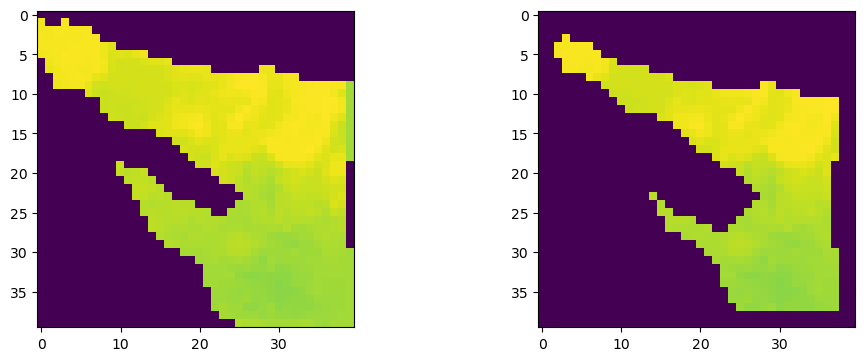

In [144]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
index = 7
ax[0].imshow((sample['mask'].view(4,1,40,40)*sample['votemper'])[0,0], vmin=0)
ax[1].imshow((sample['eroded_mask'].view(4,1,40,40)*sample['votemper'])[0,0], vmin=0)

In [136]:
%%time 
datamodule.teardown(stage='fit')

CPU times: user 9 µs, sys: 5 µs, total: 14 µs
Wall time: 18.4 µs


# Generic PyTorch Lightning Module

Logic of trainig, validation and test common for all models

In [30]:
def gradient_based_MSEloss(outputs, targets, reduction='mean') :
        outputs_grad = finite_diffs_sqr_2d_array(outputs)
        targets_grad = finite_diffs_sqr_2d_array(targets)
        
        value_loss = torch.nn.functional.mse_loss(outputs, targets, reduction=reduction)
        grad_loss = torch.nn.functional.mse_loss(outputs_grad, targets_grad, reduction=reduction)

        return (0.9*value_loss+0.1*grad_loss)    

In [31]:
class GenericPyLiModule(pl.LightningModule):
    def __init__(self, torch_model, inputs, outputs, loss, optimizer, learning_rate):
        super().__init__()
        self.torch_model = torch_model
        self.inputs = inputs
        self.outputs = outputs
        self.loss = loss
        self.save_hyperparameters(ignore=['torch_model', 'loss'])
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        
        ## initialization of weights
        #torch_model.weight.data = torch.Tensor([1.0])

    def transform_input(self, batch) :
        # transform dictionary issued from the data loader into 5D torch arrays of shape [N,L,C,H,W]
        bord = self.torch_model.cut_border_pix_input
        if bord is None :
            stacked_channels = torch.stack([batch[key] for key in self.inputs])
        else :
            stacked_channels = torch.stack([batch[key][:,:,bord:-bord,bord:-bord] for key in self.inputs])
        transform = torch.permute(stacked_channels, (1,2,0,3,4)).to(torch.float32)
        return transform
    
    def transform_target(self, batch) : 
        bord = self.torch_model.cut_border_pix_output
        if bord is None :
            stacked_channels = torch.stack([batch[key] for key in self.outputs])
        else :
            stacked_channels = torch.stack([batch[key][:,:,bord:-bord,bord:-bord] for key in self.outputs])
        transform = torch.permute(stacked_channels, (1,2,0,3,4)).to(torch.float32)
        return transform

    def evaluate_tensor_metrics_with_mask(self, metrics, batch, truth, model_output) :
        bord = self.torch_model.cut_border_pix_output
        if bord is None :
            mask = batch['eroded_mask']
        else :
            mask = batch['eroded_mask'][:,bord:-bord,bord:-bord]
        if (len(model_output.shape) == 4) : # 1 feature (1 channel) - 4D tensor
            batch_len, nb_of_levels, output_h, output_w = model_output.shape  
            valid_mask_counts = torch.count_nonzero(mask)*nb_of_levels
            mask = mask.view(batch_len,1,output_h,output_w)
            
        if (len(model_output.shape) == 5) : # 5D tensor
            batch_len, nb_of_levels, nb_of_channels, output_h, output_w = model_output.shape  
            valid_mask_counts = torch.count_nonzero(mask)*nb_of_levels*nb_of_channels
            mask = mask.view(batch_len,1,1,output_h,output_w)
    
        total_metrics = metrics(model_output*mask, truth*mask, reduction='sum')
        res_metrics = total_metrics/valid_mask_counts
        return res_metrics
    
    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.torch_model(x)
        loss_val = self.evaluate_tensor_metrics_with_mask(self.loss, batch, y_model, y_true)  
        self.log_dict({'loss_train' : loss_val}, on_step=False, on_epoch=True)
        return loss_val

    # validation logics (is evaluated during the training, but the data is not used to the optimization loop)
    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.torch_model(x)
        loss_val = self.evaluate_tensor_metrics_with_mask(self.loss, batch, y_model, y_true)  
        self.log('loss_val', loss_val, on_step=False, on_epoch=True) 
    
    # gives model output in a form of a dictionary of batches of 2d fields
    def predict_step(self, batch, batch_idx, dataloader_idx) :
        x = self.transform_input(batch)
        output_5d_tensor = self.torch_model(x)
        batch_len, nb_of_levels, nb_of_channels, output_h, output_w = output_5d_tensor.shape
        
        bord = self.torch_model.cut_border_pix_output    
        if bord is None :
            mask = batch['eroded_mask']
        else :
            mask = batch['eroded_mask'][:,bord:-bord,bord:-bord]
        mask = mask.view(batch_len,1,output_h,output_w)
            
        # construct the dictionary of the predicted features by decomposing the channels in the 4d torch tensor
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = output_5d_tensor[:, :, i, :, :].view(batch_len,nb_of_levels,output_h,output_w)
            pred[feature+'_masked'] = pred[feature].where(mask, torch.ones_like(pred[feature])*np.nan)
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = torchDataset.restore_units(pred[feature], batch, not_normalized_feature)
                pred[not_normalized_feature+'_masked'] = pred[not_normalized_feature].\
                where(mask, torch.ones_like(pred[not_normalized_feature])*np.nan)
        return pred 
    
    # testing logic - to evaluate the model after training
    def test_step(self, batch, batch_idx, dataloader_idx) :
        metrics = torch.nn.functional.mse_loss
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        
        #construct list of features on which the metrics will be evaluated
        list_of_features = list()
        for i, feature in enumerate(self.outputs) :
            list_of_features.append(feature)
            if feature.startswith('normalized_') :
                # if model output is a normalized feature then compute also the non-normalized feature 
                # and evaluate the metrics on it further
                not_normalized_feature = feature.replace("normalized_", "")
                list_of_features.append(not_normalized_feature)
        
        loss_val = dict(); loss_grad=dict(); corr_coef=dict(); corr_coef_grad=dict()
        for i, feature in enumerate(list_of_features) :
            # cut the borders if the model gives an output of reduced size
            bord = self.torch_model.cut_border_pix_output
            if bord is None :
                truth = batch[feature]
            else :
                 truth = batch[feature][:,:,bord:-bord,bord:-bord]
            model = model_output[feature]
            
            loss_val[feature] = self.evaluate_tensor_metrics_with_mask(metrics, batch, model, truth)
            ## add some other metrics for tests
            loss_grad[feature] = self.evaluate_tensor_metrics_with_mask(metrics, batch, \
                                                                         finite_diffs_sqr_2d_array(model), \
                                                                         finite_diffs_sqr_2d_array(truth))
            corr_coef[feature] = torch.corrcoef(torch.vstack((torch.flatten(model).view(1,-1), \
                                                              torch.flatten(truth).view(1,-1))))[1,0]
            corr_coef_grad[feature] = torch.corrcoef(torch.vstack((torch.flatten(finite_diffs_sqr_2d_array(model)).view(1,-1), \
                                                              torch.flatten(finite_diffs_sqr_2d_array(truth)).view(1,-1))))[1,0]
            self.log_dict({'loss_test_'+feature : loss_val[feature].mean(), \
                           'loss_grad_test_'+feature : loss_grad[feature].mean(),\
                           'corr_coef_'+feature : corr_coef[feature],\
                           'corr_coef_grad_'+feature : corr_coef_grad[feature]\
                          })

    def configure_optimizers(self) :
        optimizer = self.optimizer(self.parameters(), lr=self.learning_rate)
        return optimizer

# Experiment class

This class collects all information needed for an experiment:

In [45]:
class Experiment :
    log_directory='logs/'
    
    def __init__(self, pl_class, torch_model, label, version_name, datamodule, input_features, target_features, loss, optimizer, \
                 learning_rate=0.001, max_epochs=None, limit_train_batches=1.0, **kwargs) :
        super().__init__()
        self.label = label
        self.version_name = version_name
        
        self.pl_class = pl_class  # pytorch lightning module class
        self.torch_model = torch_model
        self.datamodule = datamodule
        self.input_features = input_features
        self.target_features = target_features
        self.loss=loss
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.limit_train_batches = limit_train_batches
        self.kwargs = kwargs
        
        # Instantiate pytorch lightning module
        self.pylight_model = self.pl_class(self.torch_model, self.input_features, self.target_features, loss=self.loss, \
                                           optimizer=self.optimizer, learning_rate=self.learning_rate, **self.kwargs)
        self.logger = pl_loggers.TensorBoardLogger(save_dir=self.log_directory, name=self.label, version=self.version_name)

    def run(self) :
        self.checkpoint_callback = ModelCheckpoint(dirpath=self.log_directory + self.label + "/" + self.version_name, \
                                              save_top_k=2, monitor="loss_val", save_last=True)
    
        self.trainer = pl.Trainer(max_epochs=self.max_epochs, logger=self.logger, limit_train_batches=self.limit_train_batches, \
                                  callbacks=[EarlyStopping(monitor="loss_val", mode="min"), self.checkpoint_callback],\
                                  accelerator='gpu', devices=(1 if torch.cuda.is_available() else None))  
        self.trainer.fit(model = self.pylight_model, datamodule=self.datamodule)
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def get_logs(self) :
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def get_checkpoint_path(self) :
        #file = glob.glob(self.log_directory + self.label + "/" + self.version_name + '/*.ckpt')[-1]
        #print(file)
        file = self.log_directory + self.label + "/" + self.version_name + '/last.ckpt'
        return file
        
    def test(self) :
        return self.trainer.test(self.pylight_model, datamodule=self.datamodule)

# Data structure for experiments

Dictionary of dictionaries for arranging experiments

In [46]:
exp = dict()

In [47]:
exp['LinReg'] = dict()
exp['FCNN'] = dict()
exp['CNN'] = dict()

# Linear regression

## Model

 Torch analog of the deterministic parametrization - linear regreaaion with only 1 parameter aimig to find coefficient $c$ in the parametrization of the form :
 $$ \sigma_T^2 \approx c |\delta \textbf{x} \cdot \nabla T|^2 $$
 where gradient norm is approximated by central finite difference scheme: 
 $$ |\delta \textbf{x} \cdot \nabla T|^2 = \frac{1}{4} \big[ T(x+\delta x,y) - T(x-\delta x, y) \big]^2 + \frac{1}{4} \big[ T(x,y+\delta y) - T(x, y-\delta y) \big]^2 $$

In [48]:
class lin_regr_model(torch.nn.Module):
    def __init__(self, nb_of_input_features, nb_of_output_features):
        super().__init__()
        self.nb_of_input_features = nb_of_input_features
        self.nb_of_output_features = nb_of_output_features
        
        self.cut_border_pix_output = None
        self.cut_border_pix_input = None
        
        self.lin1 = torch.nn.Linear(self.nb_of_input_features, self.nb_of_output_features, bias=False)
        
        # initialization 
        self.lin1.weight.data = torch.Tensor([[0.1]])

    def forward(self, x):
        batch_len, nb_of_levels, nb_of_channels, output_h, output_w = x.shape
        
        # deattach levels into batch entities by flattening
        res = x.flatten(start_dim=0, end_dim=1) # shape [N',C,H,W]
        new_batch_len = batch_len*nb_of_levels
        
        # first split the input 4D torch tensor into individual pixels (equivalent to patches of size 1x1)
        res = torch.nn.functional.unfold(res, kernel_size=1, dilation=1, padding=0, stride=1)
        res = torch.permute(res, dims=(0,2,1))
        res = torch.flatten(res, end_dim=1).to(torch.float32)
        
        # perform linear regression
        res = self.lin1(res)
        
        # reshape the model output back to a 4D torch tensor
        res = torch.permute(res.unflatten(dim=0, sizes=[new_batch_len,-1]),dims=(0,2,1))
        res = torch.nn.functional.fold(res, output_size=(output_h,output_w), kernel_size=1, dilation=1, padding=0, stride=1)

        # unflatten the levels
        res = res.unflatten(dim=0, sizes=(batch_len, nb_of_levels))
        return res

## Experiments

In [49]:
model_name = 'LinReg'

In [50]:
list_of_exps = ['valueLoss', 'gradLoss']

In [51]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [52]:
input_features_LinReg = ['normalized_diff_votemper_sqr']
output_features_LinReg = ['normalized_votemper_var']

In [53]:
exp['LinReg']['valueLoss']['exp'] = Experiment(\
                      pl_class=GenericPyLiModule, \
                      torch_model=lin_regr_model(len(input_features_LinReg), len(output_features_LinReg)), \
                      label='2d_linear_reg', \
                      version_name='masked_temp_var3D', \
                      input_features=input_features_LinReg, \
                      target_features=output_features_LinReg, 
                      datamodule=datamodule,\
                      loss = torch.nn.functional.huber_loss, \
                      optimizer = torch.optim.SGD,\
                      learning_rate = 1e-2,\
                      max_epochs=100, 
                      limit_train_batches=1.0) 

In [54]:
exp['LinReg']['gradLoss']['exp'] = Experiment(\
                      pl_class=GenericPyLiModule, \
                      torch_model=lin_regr_model(len(input_features_LinReg), len(output_features_LinReg)), \
                      label='2d_linear_reg', \
                      version_name='masked_temp_var_grad3D', \
                      input_features=input_features_LinReg, \
                      target_features=output_features_LinReg, 
                      datamodule=datamodule,\
                      loss = gradient_based_MSEloss, \
                      optimizer = torch.optim.SGD,\
                      learning_rate = 1e-3,\
                      max_epochs=100, \
                      limit_train_batches=1.0) 

## Training

In [55]:
exp['LinReg']['valueLoss']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type           | Params
-----------------------------------------------
0 | torch_model | lin_regr_model | 1     
-----------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//2d_linear_reg/masked_temp_var3D/events.out.tfevents.1671182487.jupyter-anastasiagor.1240.0


In [56]:
exp['LinReg']['gradLoss']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type           | Params
-----------------------------------------------
0 | torch_model | lin_regr_model | 1     
-----------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//2d_linear_reg/masked_temp_var_grad3D/events.out.tfevents.1671182683.jupyter-anastasiagor.1240.1


logs//2d_linear_reg/masked_temp_var3D/events.out.tfevents.1671182487.jupyter-anastasiagor.1240.0
logs//2d_linear_reg/masked_temp_var_grad3D/events.out.tfevents.1671182683.jupyter-anastasiagor.1240.1


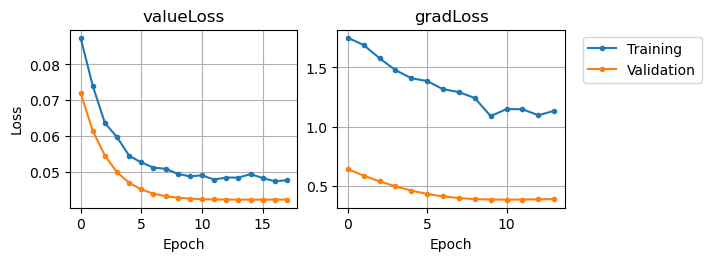

In [57]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 2.5), sharex=False, sharey=False)
exp_model = exp['LinReg']

for i, exp_name in enumerate(exp_model) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[i].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[0],marker='.', label='Training')
    ax[i].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[1], marker='.', label='Validation')
    ax[i].set(title=exp_name, xlabel='Epoch', yscale='linear')
    ax[i].grid(True)
ax[0].set(ylabel='Loss')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Fully-connected NN for patches

## Model

The torch module class describing a model that treats the inputs/outputs by patches of pixels. 

In [58]:
class FCNN(torch.nn.Module):
    def __init__(self, nb_of_input_features, nb_of_output_features, input_patch_size, output_patch_size):
        super().__init__()
        self.input_patch_size = input_patch_size
        self.output_patch_size = output_patch_size
        
        self.lin1 = torch.nn.Linear(nb_of_input_features*input_patch_size**2, 50, bias=True)
        self.lin2 = torch.nn.Linear(50, 50, bias=True)
        self.lin3 = torch.nn.Linear(50, nb_of_output_features*output_patch_size**2, bias=True)
        
        self.cut_border_pix_output = self.input_patch_size//2 - self.output_patch_size//2
        self.cut_border_pix_input = None

    def forward(self, x):
        batch_len, nb_of_levels, nb_of_channels = x.shape[0:3]
        output_h = x.shape[3]-2*(self.cut_border_pix_output)
        output_w = x.shape[4]-2*(self.cut_border_pix_output)
        
        # deattach levels into batch entities by flattening
        res = x.flatten(start_dim=0, end_dim=1) # shape [N',C,H,W]
        new_batch_len = batch_len*nb_of_levels
        
        # create patches of size 'input_patch_size' and join them into batches (zero padding - will remove border pixels)
        res = torch.nn.functional.unfold(res, kernel_size=self.input_patch_size, dilation=1, padding=0, stride=1)
        res = torch.permute(res, dims=(0,2,1))
        res = torch.flatten(res, end_dim=1)
        
        # pass though the FCNN
        res = self.lin1(res)
        res = torch.nn.functional.relu(res)
        res = self.lin2(res)
        res = torch.nn.functional.relu(res)
        res = self.lin3(res)
        
        # reshape the output patches back into a 4D torch tensor
        res = res.unflatten(dim=0, sizes=(new_batch_len,-1))
        res = torch.permute(res,dims=(0,2,1))
        res = torch.nn.functional.fold(res, output_size=(output_h,output_w), \
                                       kernel_size=self.output_patch_size, dilation=1, padding=0, stride=1)
        # compute the divider needed to get correct values in case of overlapping patches (will give mean over all overlapping patches)
        mask_ones = torch.ones((1,1,output_h,output_w)).to(x.device)
        divisor = torch.nn.functional.fold(torch.nn.functional.unfold(mask_ones, kernel_size=self.output_patch_size), \
                                           kernel_size=self.output_patch_size, output_size=(output_h,output_w))   
        res = res/divisor.view(1,1,output_h,output_w)
        
        # unflatten the levels
        res = res.unflatten(dim=0, sizes=(batch_len, nb_of_levels))
        
        return res

## Experiments

In [59]:
model_name = 'FCNN'

In [60]:
list_of_exps = ['patch_3-1', 'patch_5-3']#, 'patch_5-1', 'patch_3-1_grad', 'patch_5-3_grad','patch_5-1_grad']

In [61]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [62]:
input_features_FCNN = ['normalized_votemper']
output_features_FCNN = ['normalized_votemper_var']

In [63]:
exp['FCNN']['patch_3-1']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=FCNN(nb_of_input_features=len(input_features_FCNN), nb_of_output_features=len(output_features_FCNN), \
                                       input_patch_size=3, output_patch_size=1), \
                      label='FCNN_patched', \
                      version_name='mask_var_patch_3-1_3D', \
                      input_features=input_features_FCNN, \
                      target_features=output_features_FCNN, \
                      datamodule=datamodule,\
                      max_epochs=50, \
                      limit_train_batches=1.0,
                      loss = torch.nn.functional.mse_loss,\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-3) 

In [64]:
exp['FCNN']['patch_5-3']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=FCNN(nb_of_input_features=len(input_features_FCNN), nb_of_output_features=len(output_features_FCNN), \
                                       input_patch_size=5, output_patch_size=3), \
                      label='FCNN_patched', \
                      version_name='mask_var_patch_5-3_3D', \
                      input_features=input_features_FCNN, \
                      target_features=output_features_FCNN, \
                      datamodule=datamodule,\
                      max_epochs=100, \
                      limit_train_batches=1.0,\
                      loss = torch.nn.functional.mse_loss,\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-3)

## Training

In [65]:
exp['FCNN']['patch_3-1']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | torch_model | FCNN | 3.1 K 
-------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//FCNN_patched/mask_var_patch_3-1_3D/events.out.tfevents.1671182836.jupyter-anastasiagor.1240.2


In [66]:
exp['FCNN']['patch_5-3']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | torch_model | FCNN | 4.3 K 
-------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//FCNN_patched/mask_var_patch_5-3_3D/events.out.tfevents.1671183200.jupyter-anastasiagor.1240.3


logs//FCNN_patched/mask_var_patch_3-1_3D/events.out.tfevents.1671182836.jupyter-anastasiagor.1240.2
logs//FCNN_patched/mask_var_patch_5-3_3D/events.out.tfevents.1671183200.jupyter-anastasiagor.1240.3


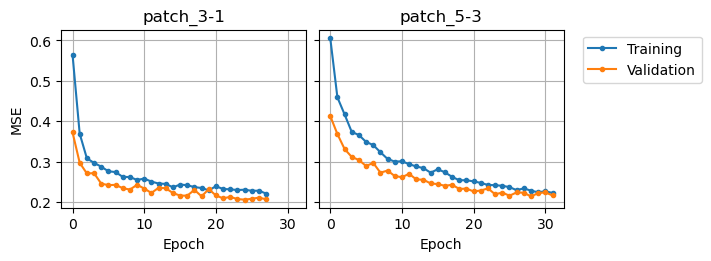

In [67]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 2.5), sharex=True, sharey=True)
exp_model = exp['FCNN']

for i, exp_name in enumerate(['patch_3-1', 'patch_5-3']) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[i].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[0], \
               marker='.', label='Training')
    ax[i].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[1], \
               marker='.', label='Validation')
    ax[i].set(title=exp_name, xlabel='Epoch'); ax[i].grid(True)
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Convolutional NN model

## Model

In [68]:
class CNN(torch.nn.Module):
    def __init__(self, nb_of_input_features, nb_of_output_features, padding='same', padding_mode='replicate', kernel_size=3):
        super().__init__()
        self.padding = padding
        self.kernel_size = kernel_size
        self.padding_mode = 'replicate'
        
        self.cut_border_pix_input = None
        if self.padding == 'same' :
            self.cut_border_pix_output = self.cut_border_pix_input
        if self.padding == 'valid' :
            self.cut_border_pix_output = (self.cut_border_pix_input or 0) + self.kernel_size//2
        
        self.conv1 = torch.nn.Conv2d(in_channels=nb_of_input_features, out_channels=64, kernel_size=self.kernel_size, \
                                     padding=self.padding,  padding_mode=self.padding_mode) 
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=self.kernel_size, padding='same', padding_mode=self.padding_mode) 
        self.conv3 = torch.nn.Conv2d(64, nb_of_output_features, kernel_size=self.kernel_size, padding='same', \
                                     padding_mode=self.padding_mode)

    def forward(self, x):
        batch_len = x.shape[0]
        nb_of_levels = x.shape[1]
        
        # deattach levels into batch entities by flattening
        res = x.flatten(start_dim=0, end_dim=1) # shape [N',C,H,W]
        
        res = self.conv1(res)
        res = torch.nn.functional.relu(res)
        res = self.conv2(res)
        res = torch.nn.functional.relu(res)
        res = self.conv3(res)
        
        # unflatten the levels
        res = res.unflatten(dim=0, sizes=(batch_len, nb_of_levels))
        return res        

## Experiments

In [69]:
model_name = 'CNN'

In [70]:
list_of_exps = ['kernel3', 'kernel5']#, 'kernel7']

In [71]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [72]:
input_features_CNN = input_features_FCNN
output_features_CNN = output_features_FCNN

In [73]:
exp['CNN']['kernel3']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=CNN(len(input_features_LinReg),len(output_features_CNN), padding='valid', kernel_size=3),\
                      label='CNN', \
                      version_name='mask_kernel3_3D', \
                      input_features=input_features_CNN, \
                      target_features=output_features_CNN, 
                      datamodule=datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0,\
                      loss = torch.nn.functional.mse_loss,\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-3) 

In [74]:
exp['CNN']['kernel5']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=CNN(len(input_features_LinReg),len(output_features_CNN), padding='valid', kernel_size=5),\
                      label='CNN', \
                      version_name='mask_kernel5_3D', \
                      input_features=input_features_CNN, \
                      target_features=output_features_CNN, 
                      datamodule=datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0,\
                      loss = torch.nn.functional.mse_loss,\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-3) 

## Training

In [75]:
exp['CNN']['kernel3']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | torch_model | CNN  | 38.1 K
-------------------------------------
38.1 K    Trainable params
0         Non-trainable params
38.1 K    Total params
0.153     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//CNN/mask_kernel3_3D/events.out.tfevents.1671183636.jupyter-anastasiagor.1240.4


In [76]:
exp['CNN']['kernel5']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | torch_model | CNN  | 105 K 
-------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.423     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//CNN/mask_kernel5_3D/events.out.tfevents.1671183974.jupyter-anastasiagor.1240.5


logs//CNN/mask_kernel3_3D/events.out.tfevents.1671183636.jupyter-anastasiagor.1240.4
logs//CNN/mask_kernel5_3D/events.out.tfevents.1671183974.jupyter-anastasiagor.1240.5


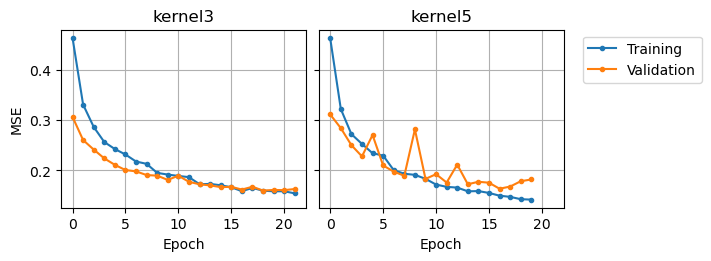

In [77]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 2.5), sharex=True, sharey=True)
exp_model = exp['CNN']

for i, exp_name in enumerate(['kernel3', 'kernel5']) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[i].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[0], \
               marker='.', label='Training')
    ax[i].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[1], \
               marker='.', label='Validation')
    ax[i].set(title=exp_name, xlabel='Epoch'); ax[i].grid(True)
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Compare results

In [78]:
%%time
test_datamodule = datamodule
test_datamodule.setup(stage='test')

CPU times: user 41 µs, sys: 24 µs, total: 65 µs
Wall time: 74.6 µs


In [79]:
list_of_models = ['LinReg', 'CNN', 'FCNN']

In [80]:
%%time
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['exp'].pylight_model
        exp_dict['best_model'] = model.load_from_checkpoint(torch_model=model.torch_model, loss=model.loss,\
                                                            checkpoint_path=exp_dict['exp'].get_checkpoint_path(), \
                                                            **exp_dict['exp'].kwargs)
        trainer = pl.Trainer(accelerator='gpu', devices=1)
        print(model_name + ' ' + exp_name)
        test_dict = trainer.test(exp_dict['best_model'], datamodule=test_datamodule)
        exp_dict['loss_vs_dataset'] = dict()
        exp_dict['loss_diffs_vs_dataset'] = dict()
        exp_dict['corr_coef_vs_dataset'] = dict()
        exp_dict['corr_coef_grad_vs_dataset'] = dict()
        for feature in ['votemper_var', 'normalized_votemper_var'] :
            if 'loss_test_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['loss_vs_dataset'][feature] = [test_dict[ds]['loss_test_'+feature+'/dataloader_idx_'+str(ds)] \
                                                        for ds in range(len(data_dict))]
            if 'loss_grad_test_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['loss_diffs_vs_dataset'][feature] = [test_dict[ds]['loss_grad_test_'+feature+'/dataloader_idx_'+str(ds)] \
                                                              for ds in range(len(data_dict))]
            if 'corr_coef_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['corr_coef_vs_dataset'][feature] = [test_dict[ds]['corr_coef_'+feature+'/dataloader_idx_'+str(ds)] \
                                                          for ds in range(len(data_dict))]
            if 'corr_coef_grad_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['corr_coef_grad_vs_dataset'][feature] = [test_dict[ds]['corr_coef_grad_'+feature+'/dataloader_idx_'+str(ds)] \
                                                          for ds in range(len(data_dict))]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LinReg valueLoss


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_normalized_votemper_var          0.5572521090507507                    0.5970228314399719
     corr_coef_grad_votemper_var                0.5572521686553955                    0.5970226526260376
  corr_coef_normalized_votemper_var             0.8010272979736328                    0.7940097451210022
        corr_coef_votemper_var                  0.8010271191596985                    0.7940099835395813
loss_grad_test_normalized_votemper_var          0.2463509738445282                   0.06683245301246643
     loss_grad_test_votemper_var               0.022775894030928612                 0.0020043840631842613
  loss_test_normalized_vo

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LinReg gradLoss


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_normalized_votemper_var          0.5572519898414612                    0.5970228314399719
     corr_coef_grad_votemper_var                0.5572522878646851                    0.5970228314399719
  corr_coef_normalized_votemper_var             0.8010269999504089                    0.7940096855163574
        corr_coef_votemper_var                  0.8010270595550537                    0.7940099239349365
loss_grad_test_normalized_votemper_var          0.2132522165775299                   0.055386994034051895
     loss_grad_test_votemper_var                0.0197158083319664                  0.0016611214959993958
  loss_test_normalized_v

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNN kernel3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_normalized_votemper_var          0.5717517137527466                    0.4622342884540558
     corr_coef_grad_votemper_var                0.5717520713806152                   0.46223434805870056
  corr_coef_normalized_votemper_var             0.5817183256149292                    0.4784458577632904
        corr_coef_votemper_var                  0.5817184448242188                    0.4784459173679352
loss_grad_test_normalized_votemper_var         0.09625730663537979                   0.024629846215248108
     loss_grad_test_votemper_var               0.00889927800744772                   0.000738678325433284
  loss_test_normalized_v

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNN kernel5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_normalized_votemper_var          0.5605812072753906                    0.4410095810890198
     corr_coef_grad_votemper_var                0.5605815052986145                    0.4410097301006317
  corr_coef_normalized_votemper_var             0.6263339519500732                    0.5018336176872253
        corr_coef_votemper_var                  0.626334011554718                     0.5018336772918701
loss_grad_test_normalized_votemper_var         0.09009947627782822                   0.021652108058333397
     loss_grad_test_votemper_var               0.008329970762133598                  0.000649372348561883
  loss_test_normalized_v

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FCNN patch_3-1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_normalized_votemper_var         0.35452911257743835                   0.11500894278287888
     corr_coef_grad_votemper_var                0.3545292615890503                    0.1150088831782341
  corr_coef_normalized_votemper_var             0.6033129096031189                    0.4324037730693817
        corr_coef_votemper_var                  0.6033128499984741                    0.4324038624763489
loss_grad_test_normalized_votemper_var         0.13044346868991852                   0.05463283881545067
     loss_grad_test_votemper_var               0.012059892527759075                 0.0016385030467063189
  loss_test_normalized_vo

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FCNN patch_5-3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_normalized_votemper_var         0.42936187982559204                   0.24322278797626495
     corr_coef_grad_votemper_var                0.4293615221977234                    0.2432226836681366
  corr_coef_normalized_votemper_var             0.6376972794532776                   0.48333239555358887
        corr_coef_votemper_var                  0.637697160243988                     0.4833323359489441
loss_grad_test_normalized_votemper_var          0.1422232836484909                   0.039429664611816406
     loss_grad_test_votemper_var               0.013148973695933819                 0.0011825424153357744
  loss_test_normalized_v

## Image example

### Region 1 : Gulfstream (FMA)

In [81]:
test_dl = test_datamodule.test_dataloader()[0]

test_di = iter(test_dl)

sample = next(test_di)

idx = 0 #index inside the batch

In [82]:
snapshot_true_error = np.squeeze(sample['votemper_var'].where(sample['mask'], torch.ones_like(sample['mask'])*np.nan))

In [83]:
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['best_model']
        exp_dict['snapshot'] = np.squeeze((model.predict_step(sample, idx, 0)['votemper_var_masked'][idx]).detach().numpy())

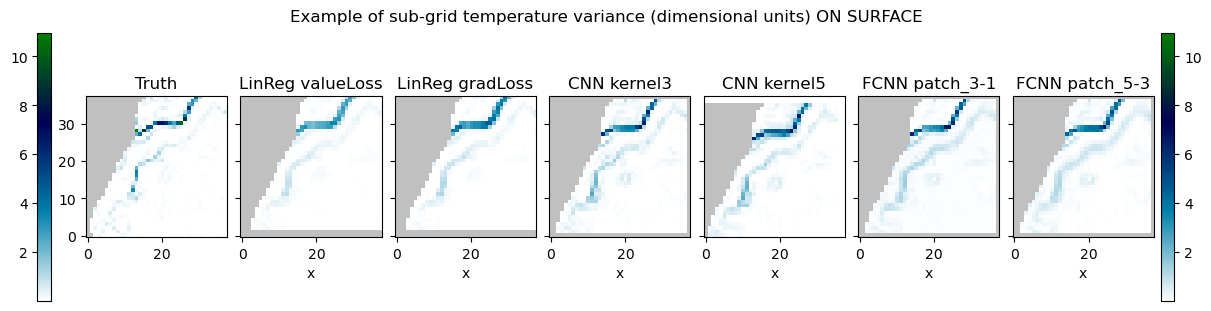

In [84]:
fig, ax = plt.subplots(ncols=7, nrows=1, figsize=(12,3), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Example of sub-grid temperature variance (dimensional units) ON SURFACE')

img = ax[0].imshow(snapshot_true_error[0,:,:], cmap='ocean_r', origin='lower')
fig.colorbar(img, location='left')
ax[0].set(title='Truth')
color_min = img.colorbar.vmin
color_max = img.colorbar.vmax
current_cmap = img.cmap
current_cmap.set_bad(color='silver')

ax_index = 1
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())[0:3]) :
        exp_dict = exp[model_name][exp_name]
        img = ax[ax_index].imshow(exp_dict['snapshot'][0,:,:], cmap=current_cmap, vmin=color_min, vmax=color_max, origin='lower')
        ax[ax_index].set(title=model_name+' '+exp_name, xlabel='x')
        ax_index+=1
fig.colorbar(img, ax=ax[-1])
    
plt.show()

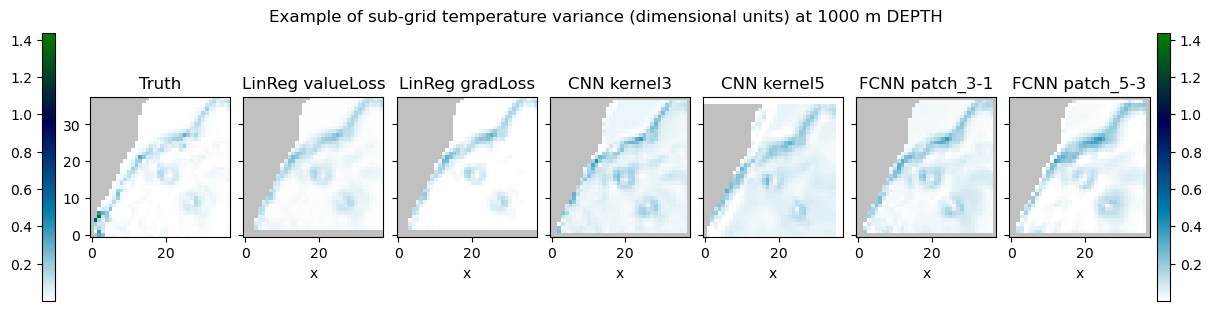

In [85]:
fig, ax = plt.subplots(ncols=7, nrows=1, figsize=(12,3), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Example of sub-grid temperature variance (dimensional units) at 1000 m DEPTH')

img = ax[0].imshow(snapshot_true_error[-1,:,:], cmap='ocean_r', origin='lower')
fig.colorbar(img, location='left')
ax[0].set(title='Truth')
color_min = img.colorbar.vmin
color_max = img.colorbar.vmax
current_cmap = img.cmap
current_cmap.set_bad(color='silver')

ax_index = 1
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())[0:3]) :
        exp_dict = exp[model_name][exp_name]
        img = ax[ax_index].imshow(exp_dict['snapshot'][-1,:,:], cmap=current_cmap, vmin=color_min, vmax=color_max, origin='lower')
        ax[ax_index].set(title=model_name+' '+exp_name, xlabel='x')
        ax_index+=1
fig.colorbar(img, ax=ax[-1])
    
plt.show()

### Region 2 - Mid Atlantic (ASO)

In [86]:
test_dl = test_datamodule.test_dataloader()[3]

test_di = iter(test_dl)

sample = next(test_di)

idx = 0 #index inside the batch

In [87]:
snapshot_true_error = np.squeeze(sample['votemper_var'].where(sample['mask'], torch.ones_like(sample['mask'])*np.nan))

In [88]:
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['best_model']
        exp_dict['snapshot'] = np.squeeze((model.predict_step(sample, idx, 0)['votemper_var_masked'][idx]).detach().numpy())

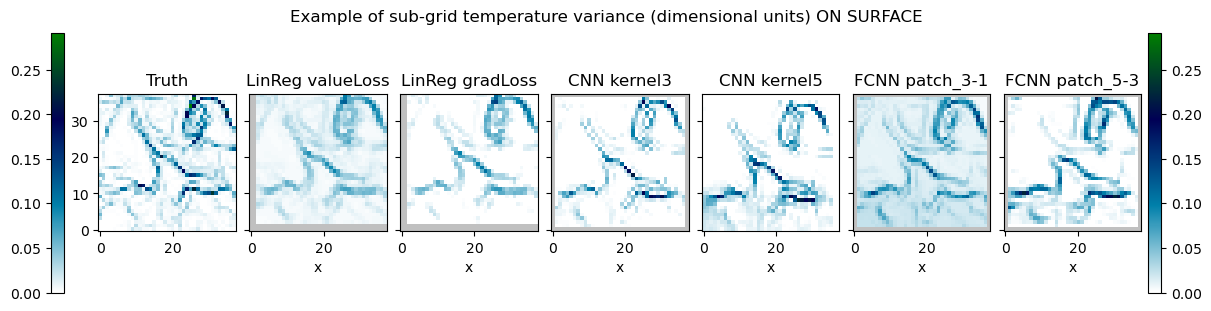

In [89]:
fig, ax = plt.subplots(ncols=7, nrows=1, figsize=(12,3), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Example of sub-grid temperature variance (dimensional units) ON SURFACE')

img = ax[0].imshow(snapshot_true_error[0,:,:], cmap='ocean_r', origin='lower')
fig.colorbar(img, location='left')
ax[0].set(title='Truth')
color_min = img.colorbar.vmin
color_max = img.colorbar.vmax
current_cmap = img.cmap
current_cmap.set_bad(color='silver')

ax_index = 1
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())[0:3]) :
        exp_dict = exp[model_name][exp_name]
        img = ax[ax_index].imshow(exp_dict['snapshot'][0,:,:], cmap=current_cmap, vmin=color_min, vmax=color_max, origin='lower')
        ax[ax_index].set(title=model_name+' '+exp_name, xlabel='x')
        ax_index+=1
fig.colorbar(img, ax=ax[-1])
    
plt.show()

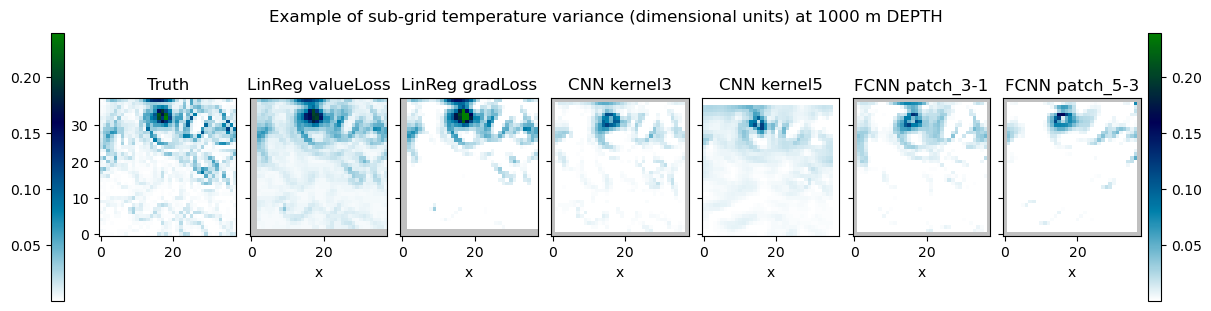

In [90]:
fig, ax = plt.subplots(ncols=7, nrows=1, figsize=(12,3), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Example of sub-grid temperature variance (dimensional units) at 1000 m DEPTH')

img = ax[0].imshow(snapshot_true_error[-1,:,:], cmap='ocean_r', origin='lower')
fig.colorbar(img, location='left')
ax[0].set(title='Truth')
color_min = img.colorbar.vmin
color_max = img.colorbar.vmax
current_cmap = img.cmap
current_cmap.set_bad(color='silver')

ax_index = 1
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())[0:3]) :
        exp_dict = exp[model_name][exp_name]
        img = ax[ax_index].imshow(exp_dict['snapshot'][-1,:,:], cmap=current_cmap, vmin=color_min, vmax=color_max, origin='lower')
        ax[ax_index].set(title=model_name+' '+exp_name, xlabel='x')
        ax_index+=1
fig.colorbar(img, ax=ax[-1])
    
plt.show()

### Region 3 - WEDMED (ASO)

In [91]:
test_dl = test_datamodule.test_dataloader()[5]

test_di = iter(test_dl)

sample = next(test_di)

idx = 0 #index inside the batch

In [92]:
snapshot_true_error = np.squeeze(sample['votemper_var'].where(sample['mask'], torch.ones_like(sample['mask'])*np.nan))

In [93]:
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['best_model']
        exp_dict['snapshot'] = np.squeeze((model.predict_step(sample, idx, 0)['votemper_var_masked'][idx]).detach().numpy())

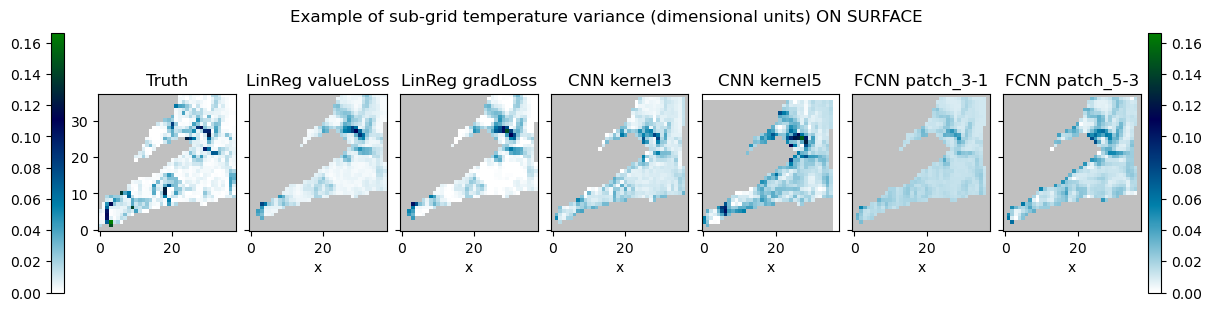

In [111]:
fig, ax = plt.subplots(ncols=7, nrows=1, figsize=(12,3), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Example of sub-grid temperature variance (dimensional units) ON SURFACE')

img = ax[0].imshow(snapshot_true_error[0,:,:], cmap='ocean_r', origin='lower')
fig.colorbar(img, location='left')
ax[0].set(title='Truth')
color_min = img.colorbar.vmin
color_max = img.colorbar.vmax
current_cmap = img.cmap
current_cmap.set_bad(color='silver')

ax_index = 1
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())[0:3]) :
        exp_dict = exp[model_name][exp_name]
        img = ax[ax_index].imshow(exp_dict['snapshot'][0,:,:], cmap=current_cmap, vmin=color_min, vmax=color_max, origin='lower')
        ax[ax_index].set(title=model_name+' '+exp_name, xlabel='x')
        ax_index+=1
fig.colorbar(img, ax=ax[-1])
    
plt.show()

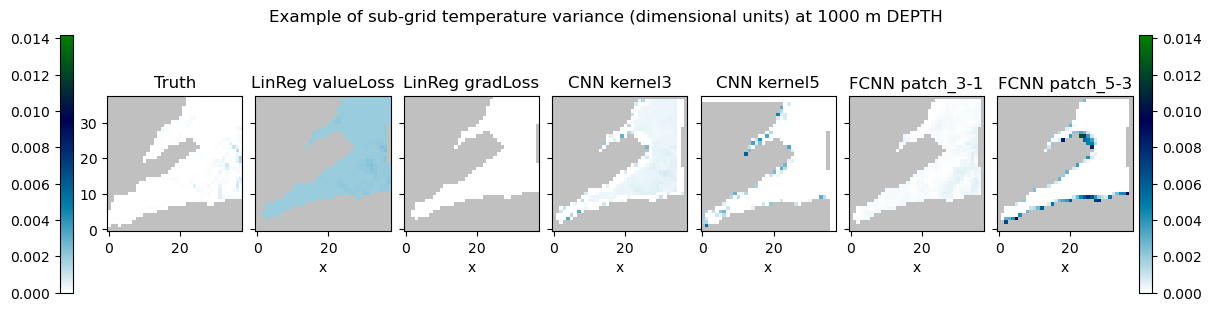

In [112]:
fig, ax = plt.subplots(ncols=7, nrows=1, figsize=(12,3), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Example of sub-grid temperature variance (dimensional units) at 1000 m DEPTH')

img = ax[0].imshow(snapshot_true_error[-1,:,:], cmap='ocean_r', origin='lower')
fig.colorbar(img, location='left')
ax[0].set(title='Truth')
color_min = img.colorbar.vmin
color_max = img.colorbar.vmax
current_cmap = img.cmap
current_cmap.set_bad(color='silver')

ax_index = 1
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())[0:3]) :
        exp_dict = exp[model_name][exp_name]
        img = ax[ax_index].imshow(exp_dict['snapshot'][-1,:,:], cmap=current_cmap, vmin=color_min, vmax=color_max, origin='lower')
        ax[ax_index].set(title=model_name+' '+exp_name, xlabel='x')
        ax_index+=1
fig.colorbar(img, ax=ax[-1])
    
plt.show()

## Metrics over all datasets

In [113]:
bar_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values())

In [114]:
metrics_list = ['loss_vs_dataset', 'loss_diffs_vs_dataset', 'corr_coef_vs_dataset', 'corr_coef_grad_vs_dataset']

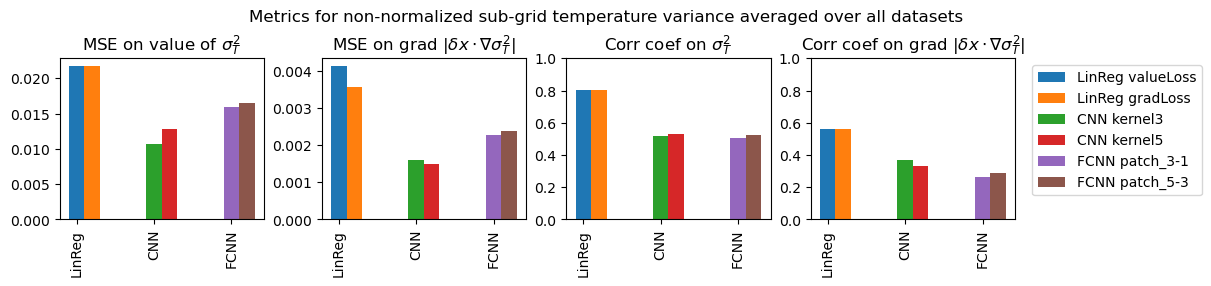

In [115]:
fig, ax = plt.subplots(1, len(metrics_list), constrained_layout=True, figsize=(3.0*len(metrics_list), 2.75))
fig.suptitle('Metrics for non-normalized sub-grid temperature variance averaged over all datasets')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'votemper_var'
for idx, metrics in enumerate(metrics_list) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]

            ax[idx].bar(x[i]+j*bar_width, np.mean(exp_dict[metrics][feature]), width=bar_width, \
                           color=bar_colors[bar_counter],label=model_name+' '+exp_name)
            bar_counter+=1
    ax[idx].set_xticks(x, xlabels, rotation='vertical') 
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax[2::] :
    axis.set(ylim=[0,1])

ax[0].set(title=r'MSE on value of $\sigma_T^2$')
ax[1].set(title=r'MSE on grad $|\delta x \cdot \nabla \sigma_T^2|$')
ax[2].set(title=r'Corr coef on $\sigma_T^2$')
ax[3].set(title=r'Corr coef on grad $|\delta x \cdot \nabla \sigma_T^2|$')
plt.show()

## Compare MSE across datasets (by region/season)

### MSE of subgrid variance

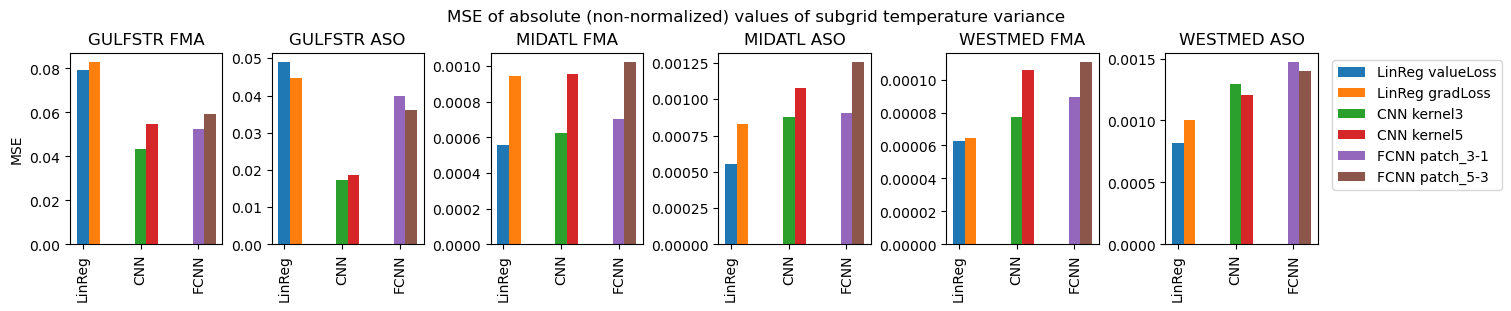

In [116]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('MSE of absolute (non-normalized) values of subgrid temperature variance')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'votemper_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_vs_dataset'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['loss_vs_dataset'][feature][region], width=bar_width, \
                               color=bar_colors[bar_counter],\
                              label=model_name+' '+exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### MSE of horizontal gradient of the subgrid variance

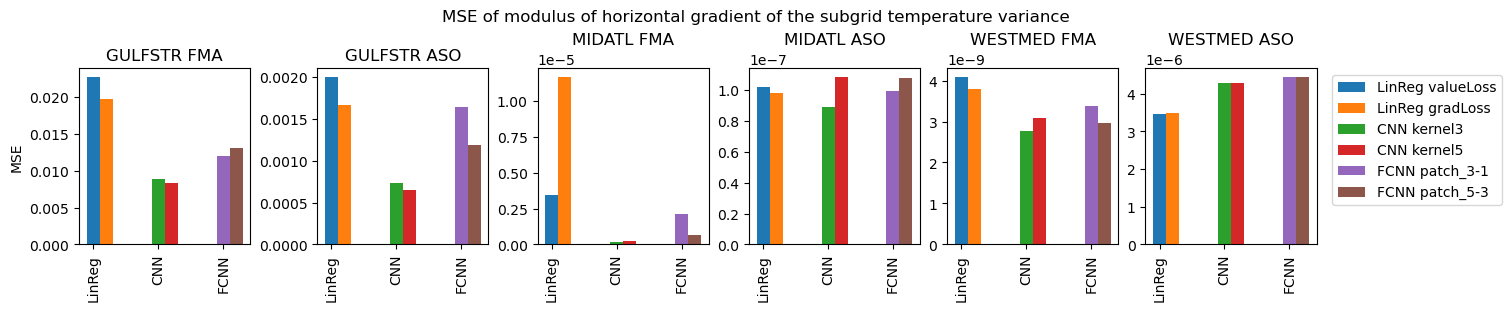

In [117]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('MSE of modulus of horizontal gradient of the subgrid temperature variance')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'votemper_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_diffs_vs_dataset'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['loss_diffs_vs_dataset'][feature][region], width=bar_width, \
                               color=bar_colors[bar_counter],\
                              label=model_name+' '+exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Correlation coefficient

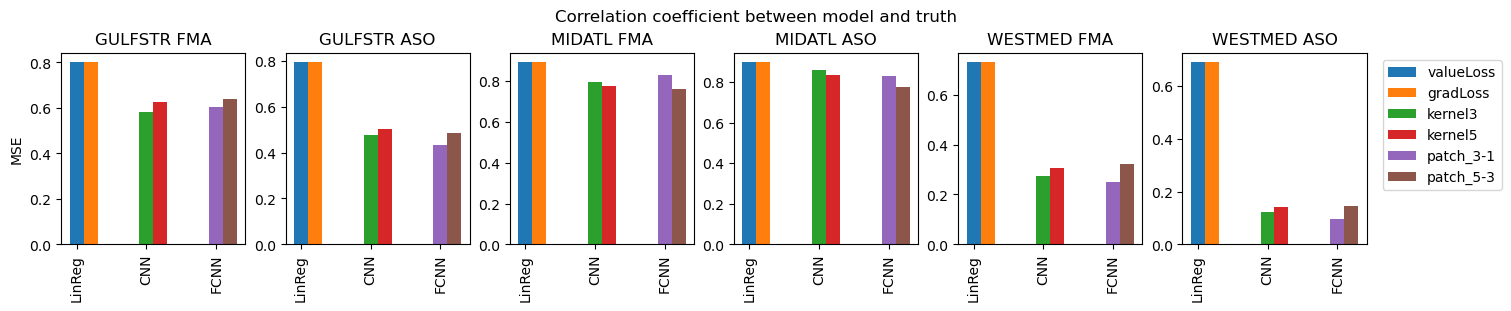

In [118]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('Correlation coefficient between model and truth')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'votemper_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_vs_dataset'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['corr_coef_vs_dataset'][feature][region], width=bar_width, \
                               color=bar_colors[bar_counter],\
                              label=exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Correlation coefficient on gradients

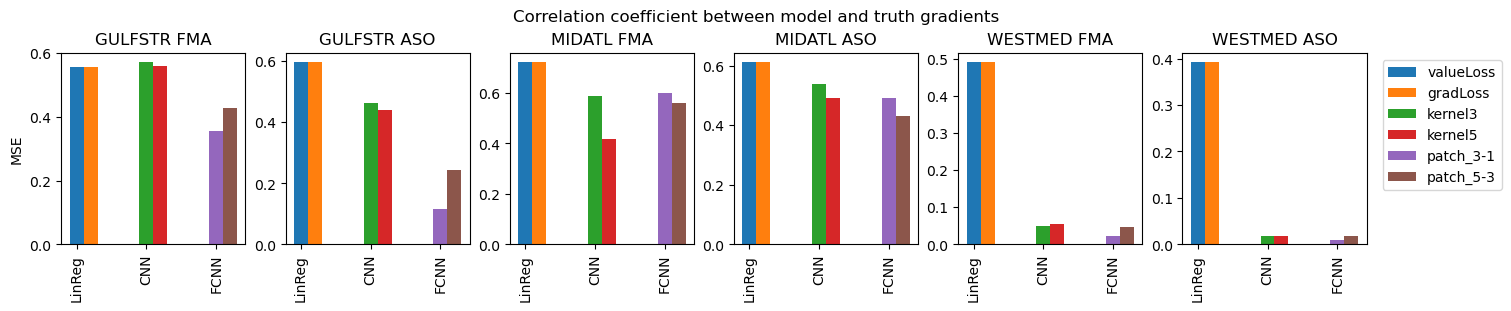

In [119]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('Correlation coefficient between model and truth gradients')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'votemper_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_vs_dataset'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['corr_coef_grad_vs_dataset'][feature][region], width=bar_width, \
                               color=bar_colors[bar_counter],\
                              label=exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Vertical profiles

In [201]:
test_dl = test_datamodule.test_dataloader()[3]

test_di = iter(test_dl)

sample = next(test_di)

batch_idx = 0 #index inside the batch

In [202]:
sample['votemper_var'].shape

torch.Size([1, 107, 40, 40])

In [203]:
random_points = [dict({'x': randrange(1,sample['votemper_var'].shape[2]-4), \
                       'y': randrange(1,sample['votemper_var'].shape[3]-4)}) for i in range(6)]

In [204]:
random_points

[{'x': 26, 'y': 14},
 {'x': 18, 'y': 1},
 {'x': 35, 'y': 24},
 {'x': 22, 'y': 8},
 {'x': 35, 'y': 26},
 {'x': 24, 'y': 2}]

## Subgrid temp variance

In [205]:
true_cube = np.squeeze(sample['votemper_var'].where(sample['mask'], torch.ones_like(sample['mask'])*np.nan))

In [206]:
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['best_model']
        exp_dict['cube'] = np.squeeze((model.predict_step(sample, batch_idx, 0)['votemper_var_masked'][batch_idx]).detach().numpy())

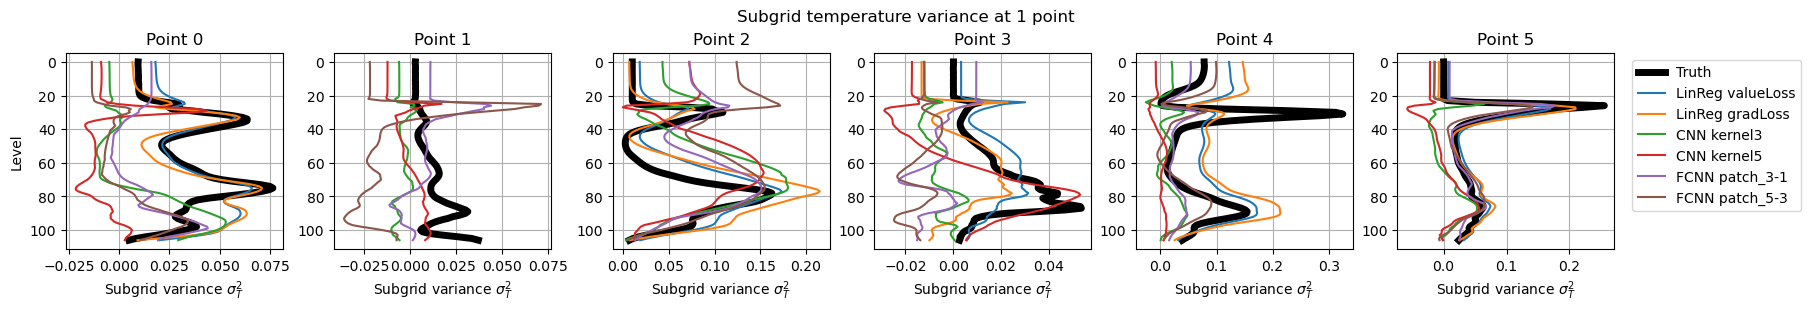

In [207]:
fig, ax = plt.subplots(1, len(random_points), constrained_layout=True, figsize=(3*len(random_points), 3), sharex=False,sharey=False)
y_vals = np.arange(true_cube.shape[0])
fig.suptitle('Subgrid temperature variance at 1 point')

for idx, point in enumerate(random_points):
    x = point['x']
    y = point['y']
    x_vals = true_cube[:,x,y]
    ax[idx].plot(x_vals, y_vals, label='Truth', lw=5, color='k')
    line_counter = 1
    for model_name in list_of_models :
        for exp_name in list(exp[model_name].keys()) :
            x_vals = exp[model_name][exp_name]['cube'][:,x,y]
            ax[idx].plot(x_vals, y_vals, label=model_name+' '+exp_name, color=bar_colors[line_counter-1])
            line_counter+=1
    ax[idx].invert_yaxis() 
    ax[idx].set(xlabel=r'Subgrid variance $\sigma_T^2$', title='Point '+str(idx))
    ax[idx].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

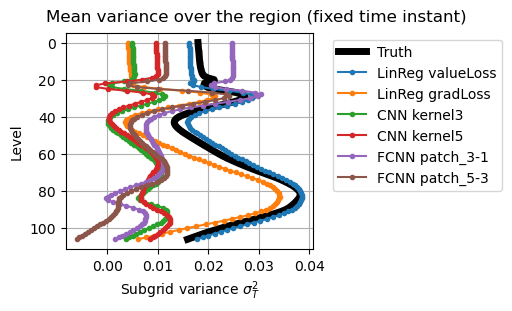

In [208]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3))
y_vals = np.arange(true_cube.shape[0])
fig.suptitle('Mean variance over the region (fixed time instant)')
x_vals = np.nanmean(true_cube[:,:,:], axis=(1,2))
ax.plot(x_vals, y_vals, marker='.', label='Truth', color='k', lw=5)
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        x_vals = np.nanmean(exp[model_name][exp_name]['cube'][:,:,:], axis=(1,2))
        ax.plot(x_vals, y_vals, marker='.', label=model_name+' '+exp_name)
ax.invert_yaxis() 
ax.set(ylabel='Level', xlabel=r'Subgrid variance $\sigma_T^2$')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Horizontal grad of subgrid temp variance

In [209]:
true_cube = np.squeeze(finite_diffs_sqr_2d_array(sample['votemper_var'].where(sample['mask'], torch.ones_like(sample['mask'])*np.nan)))

In [210]:
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['best_model']
        exp_dict['cube'] = np.squeeze((finite_diffs_sqr_2d_array(model.predict_step(sample, batch_idx, 0)['votemper_var_masked'][batch_idx])).detach().numpy())

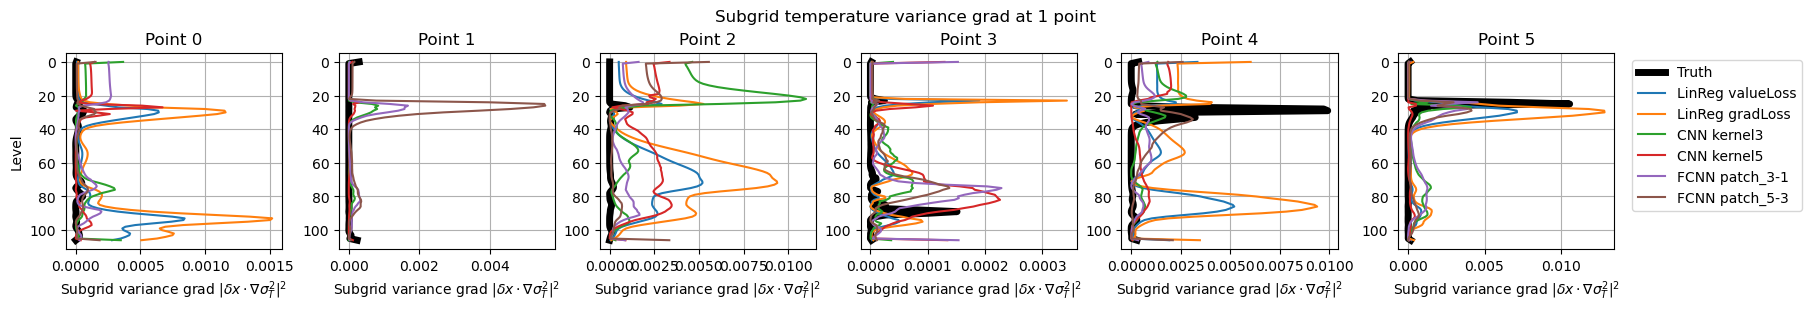

In [211]:
fig, ax = plt.subplots(1, len(random_points), constrained_layout=True, figsize=(3*len(random_points), 3), sharex=False,sharey=False)
y_vals = np.arange(true_cube.shape[0])
fig.suptitle('Subgrid temperature variance grad at 1 point')

for idx, point in enumerate(random_points):
    x = point['x']
    y = point['y']
    x_vals = true_cube[:,x,y]
    ax[idx].plot(x_vals, y_vals, label='Truth', lw=5, color='k')
    line_counter = 1
    for model_name in list_of_models :
        for exp_name in list(exp[model_name].keys()) :
            x_vals = exp[model_name][exp_name]['cube'][:,x,y]
            ax[idx].plot(x_vals, y_vals, label=model_name+' '+exp_name, color=bar_colors[line_counter-1])
            line_counter+=1
    ax[idx].invert_yaxis() 
    ax[idx].set(xlabel=r'Subgrid variance grad $|\delta x \cdot \nabla \sigma_T^2|^2$', title='Point '+str(idx))
    ax[idx].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

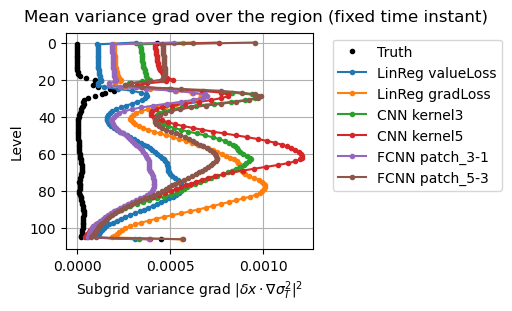

In [217]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3))
y_vals = np.arange(true_cube.shape[0])
fig.suptitle('Mean variance grad over the region (fixed time instant)')
x_vals = np.nanmean(true_cube[:,:,:], axis=(1,2))
ax.plot(x_vals, y_vals, marker='.', label='Truth', color='k', lw=3, ls='')
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        x_vals = np.nanmean(exp[model_name][exp_name]['cube'][:,:,:], axis=(1,2))
        ax.plot(x_vals, y_vals, marker='.', label=model_name+' '+exp_name, ls='-')
ax.invert_yaxis() 
ax.set(ylabel='Level', xlabel=r'Subgrid variance grad $|\delta x \cdot \nabla \sigma_T^2|^2$')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()